In [1]:
import tensorflow as tf
import numpy as np

from src.Objective import Objective
from src.Parameterization import Parameterization, to_valid_rgb
from src.Transformation import *
from src.Regularizer import *
from src.Optimizer import *
from src.Miscellaneous import load_image
from src.Attribution import *
from src.Wrapper import *
from src.DGN_AM import DGN_AM
from src.VAE import VAE

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [11]:
model = Wrapper('VGG16')

print(model.layers())

['input_5', 'block1_conv1', 'block1_conv2', 'block1_pool', 'block2_conv1', 'block2_conv2', 'block2_pool', 'block3_conv1', 'block3_conv2', 'block3_conv3', 'block3_pool', 'block4_conv1', 'block4_conv2', 'block4_conv3', 'block4_pool', 'block5_conv1', 'block5_conv2', 'block5_conv3', 'block5_pool', 'flatten', 'fc1', 'fc2', 'predictions']


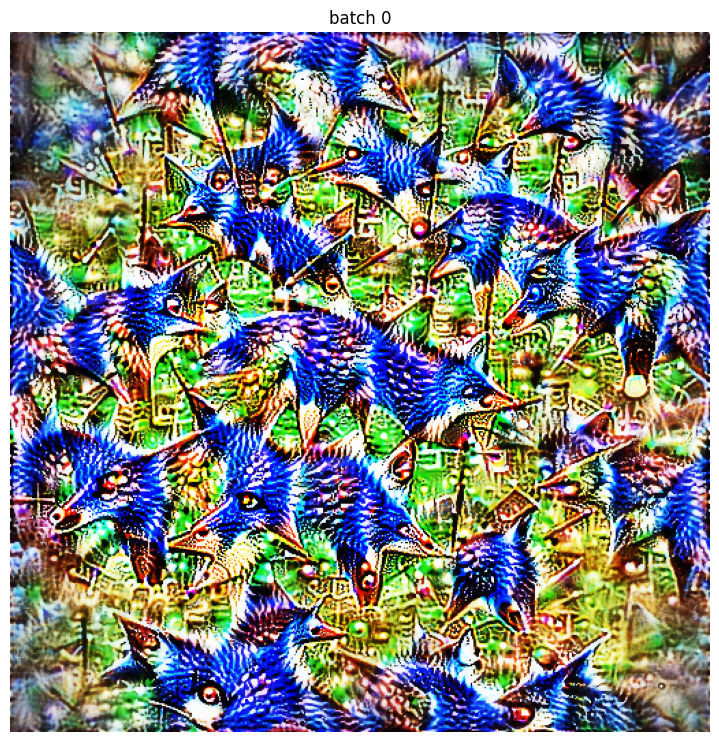

In [12]:
p = Parameterization.image_fft(512)

o = Objective.channel(model, -1, 277)
    
images = run(o, p, steps = 1000, 
             learning_rate = 0.1,
             verbose = False)

plot_all(images)

tf.keras.utils.save_img(f'images_doc/obj/logits/VGG16.png', images[0][0])

In [ ]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_png(img, channels = 3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [256, 256])

classes = [str(i) for i in range(200)]

def get_bytes_and_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
 
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, parts[-2] == classes

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 64
BUFFER_SIZE = 60000

def createDataset(path, batch_size, buffer_size):
    dataset = tf.data.Dataset.list_files(path + '/*/images/*.JPEG')
    dataset = dataset.map(get_bytes_and_label, num_parallel_calls = AUTOTUNE)

    return dataset.cache().shuffle(buffer_size = buffer_size).batch(batch_size = batch_size).prefetch(buffer_size = AUTOTUNE)

In [ ]:
T = True

if T:
    dataset = createDataset('src/tiny-imagenet-200/train copy', BATCH_SIZE, BUFFER_SIZE)

    LATENT_DIM = 256

    vae = VAE(200, LATENT_DIM, BATCH_SIZE, (256, 256, 3))

    #vae.load('src/models')
    vae.train('src/models', dataset, 10, verbose = True)

: 

: 

In [ ]:
images = run_dgn_am('src/models', model, 20, steps = 500, learning_rate = 0.1,
                    verbose = False)

plot_all(images)

In [ ]:
o = Objective.channel(model, -1, 20)
p = Parameterization.image_fft(64)

images = run(o, p, learning_rate = 0.1, steps = 500, 
             verbose = False, image_shape = (64, 64))

plot_all(images)